In [6]:
import shutil
import os
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt
import json
import glob
import pandas as pd
from tqdm import tqdm
from collections import namedtuple
from tqdm import tqdm
import cv2

from aug_utils import *
from bbox_util import *

In [ ]:
shutil.unpack_archive("drive/MyDrive/RDD2020_data.tar.gz.tar", os.getcwd())
shutil.unpack_archive(os.path.join(os.getcwd(), "keras-frcnn.zip"), os.getcwd())

In [ ]:
IMG_FOLDER = os.getcwd() + "/RDD2020_data/images/"
XML_FOLDER = os.getcwd() + "/RDD2020_data/annotations/xmls/"

## No of images from original dataset

In [ ]:
len(os.listdir(IMG_FOLDER))

13376

## Image Augmentation

In [ ]:
for filename in os.listdir(IMG_FOLDER):
  xml_filename = filename.split(".")[0]+".xml"
  image_name = filename.split(".")[0]
  if image_name[-2] == '-':
    continue
  if os.path.exists(XML_FOLDER+xml_filename):
    img = cv2.imread(IMG_FOLDER+"/"+filename)[:, :, ::-1]
    tree = ET.parse(XML_FOLDER+xml_filename)
    root = tree.getroot()
    bndbox = np.zeros((len(root.findall('object')), 4))
    i = 0
    if not len(root.findall("object")) > 0:
      continue
    for ob in root.findall("object"):
      for box in ob.findall('bndbox'):
        bndbox[i] = [int(box[i].text) for i in range(4)]
      i += 1
    # plot_img = draw_rect(img, bndbox)
    seq = [RandomHSV(40, 40, 30), RandomHorizontalFlip(1), Resize(500), RandomScale(0.3, diff = True), RandomTranslate(0.3, diff = True), RandomRotate(10), RandomShear(0.2)]
    # fig = plt.figure(figsize=(15, 15))
    for i, aug in enumerate(seq):
      img_, bboxes_ = aug(img.copy(), bndbox.copy())
      # if len_before > len_after and before == filename:
      #   plotted_img = draw_rect(img_, bboxes_)
      #   plt.figure(figsize=(15, 15))
      #   plt.imshow(plotted_img)
      #   break
      # else:
      tree = ET.parse(XML_FOLDER+xml_filename)
      root = tree.getroot()
      root[1].text = image_name+"-"+str(i)+".jpg"
      k = 0
      for o in root.iter("object"):
        if k < len(bboxes_):
          for box in o.iter('bndbox'):
            for j in range(4):
              box[j].text = str(bboxes_[k][j])
        else:
          root.remove(o)
        k += 1
      cv2.imwrite(IMG_FOLDER+"/"+image_name+"-"+str(i)+".jpg", img_)
      tree.write(XML_FOLDER+image_name+"-"+str(i)+".xml")
      # display augmented images

      # plotted_img = draw_rect(img_, bboxes_)
      # fig.add_subplot(3, 3, i+1)
      # plt.imshow(plotted_img)
    else:
      continue
    break

/content/bbox_util.py:79: RuntimeWarning: invalid value encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)


In [ ]:
len(os.listdir(IMG_FOLDER))

84678

In [ ]:
def plot_augmentation(filename):
  f = plt.figure(figsize=(20, 20))
  for i in range(7):
    img = cv2.imread(IMG_FOLDER+filename+"-"+str(i)+".jpg")[:, :, ::-1]
    t = ET.parse(XML_FOLDER+filename+"-"+str(i)+".xml")
    bndbox = np.zeros((len(root.findall('object')), 4))
    j = 0
    for ob in t.getroot().findall("object"):
      bndbox[j] = [float(ob[4][k].text) for k in range(4)]
      j += 1
    plot_img = draw_rect(img.copy(), bndbox.copy())
    f.add_subplot(3, 3, i+1)
    plt.imshow(plot_img)

In [19]:
def plot_damage(filename):
  f = plt.figure(figsize=(15, 15))
  img = cv2.imread(filename+".jpg")[:, :, ::-1]
  t = ET.parse(XML_FOLDER+filename+".xml")
  bndbox = np.zeros((len(t.getroot().findall('object')), 4))
  j = 0
  for ob in t.getroot().findall("object"):
    bndbox[j] = [float(ob[4][k].text) for k in range(4)]
    j += 1
  plot_img = draw_rect(img.copy(), bndbox.copy())
  plt.imshow(plot_img)

In [49]:
l = [
      [0.496094, 0.819907, 0.045312, 0.152778],
      [0.655990, 0.862037, 0.306771, 0.012963]
    ]
# l = [[l[i][j] * 1920 for j in range(4)] for i in range(len(l))]
l = [[l[i][j] * 1920 if j % 2 == 0 else l[i][j] * 1080 for j in range(4)] for i in range(len(l))]
print(l)
copy = l
copy[0][2] += copy[0][0]
copy[0][3] += copy[0][1]
copy[1][2] += copy[1][0]
copy[1][3] += copy[1][1]
copy

[[952.5004799999999, 885.4995600000001, 86.99904, 165.00024], [1259.5008, 930.9999600000001, 589.00032, 14.00004]]


[[952.5004799999999, 885.4995600000001, 1039.4995199999998, 1050.4998],
 [1259.5008, 930.9999600000001, 1848.50112, 945.0000000000001]]

1920 1080


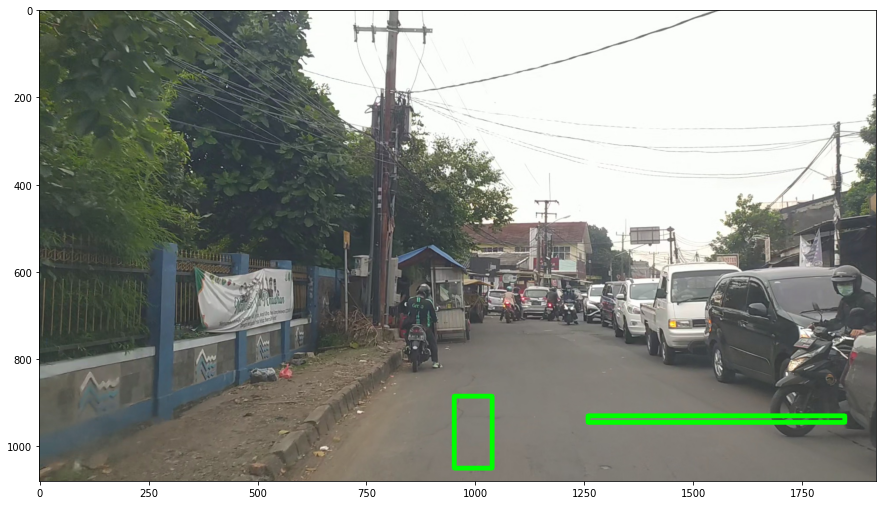

In [48]:
f = plt.figure(figsize=(15, 15))
img = cv2.imread("AB_1020.jpeg")
height, width = img.shape[:2]
img = img[:, :, ::-1]
bndbox = np.asarray(copy)
print(width, height)
plot_img = draw_rect(img.copy(), bndbox.copy())
plt.imshow(plot_img)

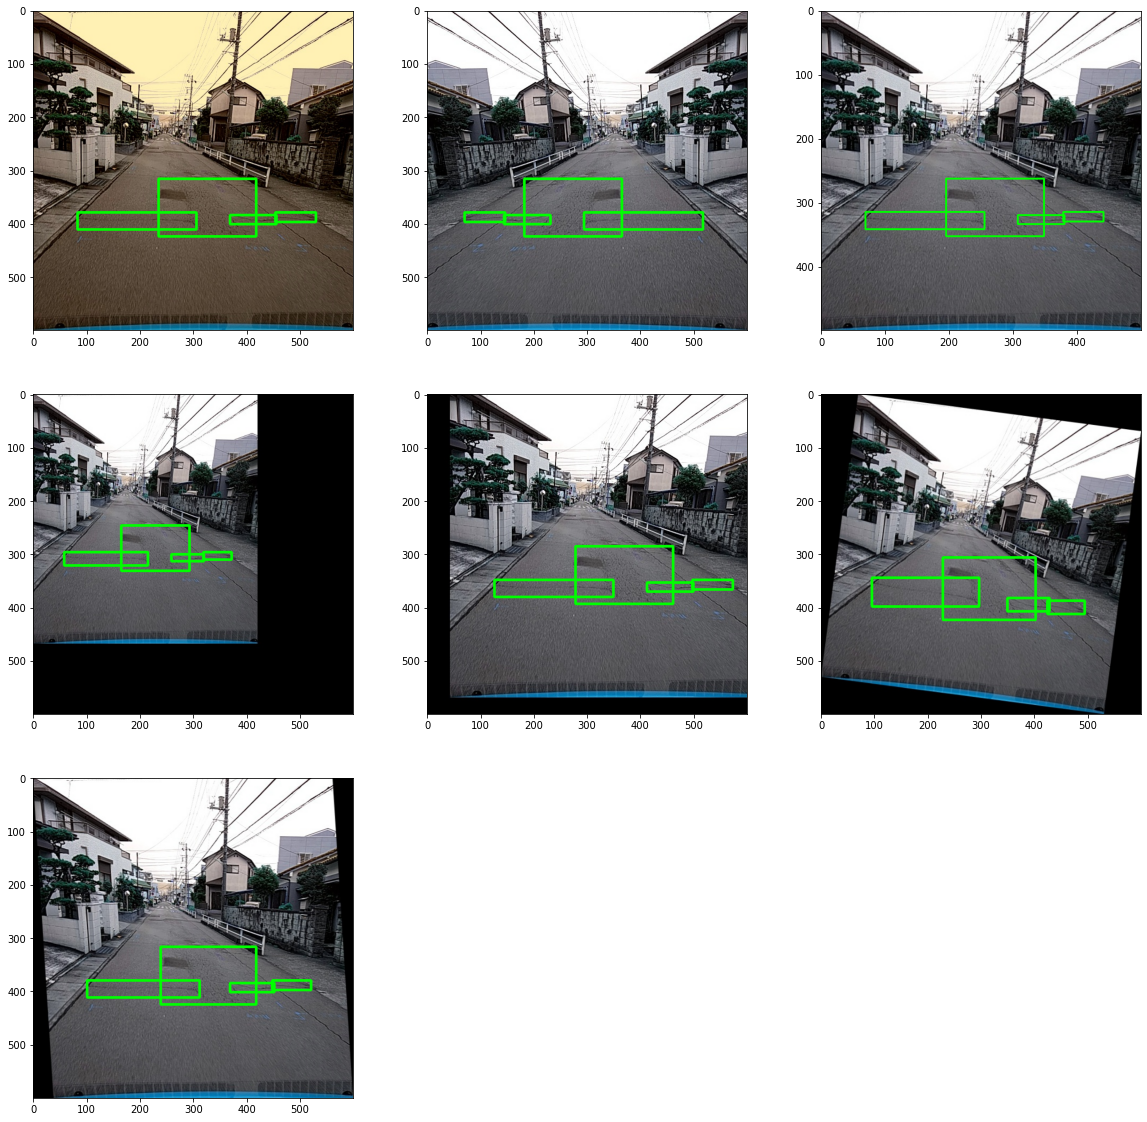

In [ ]:
plot_augmentation("Numazu_20170906085503")

In [ ]:
def __list_to_csv(annotations, output_file):
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(annotations, columns=column_name)
  xml_df.to_csv(output_file, index=None)


def xml_to_csv(xml_dir, output_file):
  """Reads all XML files, generated by labelImg, from a directory and generates a single CSV file"""
  annotations = []
  for xml_file in tqdm(glob.glob(xml_dir + '/*.xml')):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      for bnd in member.findall('bndbox'):
        filename = root.find('filename').text
        if filename.endswith(".png"):
          filename = filename.split(".")[0] + ".jpg"
        if os.path.exists(os.path.join(IMG_FOLDER, filename)):
          value = (filename,
          int(root.find('size')[0].text),
          int(root.find('size')[1].text),
          member[0].text,
          int(bnd[0].text),
          int(bnd[1].text),
          int(bnd[2].text),
          int(bnd[3].text))
          annotations.append(value)

  __list_to_csv(annotations, output_file)

xml_to_csv(XML_FOLDER, os.path.join(os.getcwd(), "data.csv"))

100%|██████████| 10976/10976 [00:00<00:00, 11163.63it/s]


In [ ]:
df = pd.read_csv("data.csv")
with open("label.names", "w") as f:
  for lab in sorted(df["class"].unique()):
    print(lab, file=f)

In [ ]:
def __split(df, group):
   data = namedtuple('data', ['filename', 'object'])
   gb = df.groupby(group)
   return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def yolo_txt_from_csv(input_csv, input_names, output_file):
  with open(input_names, "r") as file:
    names = file.read().split('\n')
    df = pd.read_csv(input_csv)

  grouped = __split(df, 'filename')
  xs = []
  ys = []
  xl = []
  yl = []
  classes = []
  filenames = []

  for group in tqdm(grouped, desc='groups'):
    filename = group.filename

    for _, row in group.object.iterrows():
      if not set(['class', 'width', 'height', 'xmin', 'xmax', 'ymin', 'ymax']).issubset(
      set(row.index)):
        pass

      img_width = row['width']
      img_height = row['height']

      xmin = row['xmin']
      ymin = row['ymin']
      xmax = row['xmax']
      ymax = row['ymax']

      xs.append(xmin)
      ys.append(ymin)
      xl.append(xmax)
      yl.append(ymax)
      classes.append(row['class'])
      filenames.append(filename)

  with open(output_file, 'w+') as f:
    for i in range(len(classes)):
      f.write('{},{},{},{},{},{}\n'.format(IMG_FOLDER+filenames[i],
                                            xs[i],
                                            ys[i],
                                            xl[i],
                                            yl[i],
                                            names.index(classes[i])))

yolo_txt_from_csv(os.getcwd()+"/data.csv", "label.names", os.path.join(os.getcwd(), "RDD2020_data", "annotations", "annotations.txt"))

groups: 100%|██████████| 10186/10186 [00:04<00:00, 2295.15it/s]


In [ ]:
# !git clone https://github.com/kbardool/keras-frcnn.git

Cloning into 'keras-frcnn'...
remote: Enumerating objects: 635, done.
remote: Total 635 (delta 0), reused 0 (delta 0), pack-reused 635
Receiving objects: 100% (635/635), 187.79 KiB | 7.22 MiB/s, done.
Resolving deltas: 100% (433/433), done.


## Training the model

In [ ]:
!python /content/keras-frcnn/train_frcnn.py -o simple -p /content/RDD2020_data/annotations/annotations.txt --num_epochs 10

2021-03-21 14:41:24.002982: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Parsing annotation files
Parsing annotation files
Training images per class:
{'0': 4387,
 '1': 4262,
 '2': 6586,
 '3': 2259,
 '4': 744,
 '5': 4157,
 '6': 3728,
 'bg': 0}
Num classes (including bg) = 8
Config has been written to config.pickle, and can be loaded when testing to ensure correct results
Num train samples 10186
Num val samples 10186
2021-03-21 14:44:01.549441: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-21 14:44:01.550971: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-21 14:44:01.562999: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-21 14:44:01.563101: I tensorflow/stream_executor/cuda/cuda_di

In [ ]:
def delete_folder(folder_name):
  for filename in os.listdir(os.path.join(os.getcwd(), folder_name)):
      file_path = os.path.join(os.path.join(os.getcwd(), folder_name), filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
delete_folder("RDD2020_data")